In [1]:
import pandas as pd
import contextily as ctx
from mapbox import Directions
import googlemaps
import multiprocessing
from functools import partial
import plotly.express as px
from googlemaps import Client as GoogleMaps
from datetime import datetime
from scipy.ndimage import gaussian_filter
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from tobler.util import h3fy
import geopandas as gpd
from pandana.loaders import osm
import geopandas as gpd
import mapclassify
import pydeck as pdk
import networkx as nx
from shapely.geometry import Point, LineString
import multiprocessing
from tobler.area_weighted import area_interpolate
import plotly.io as pio
import transbigdata as tbd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import requests
import dask
import datashader as ds
import datashader.transfer_functions as tf
from shapely.geometry import LineString, MultiLineString, Point
import plotly.express as px
import io
import zipfile
import warnings
import numpy as np
import matplotlib.cm as cm
import folium
from matplotlib.colors import LogNorm
import networkx as nx
import osmnx as ox
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import contextily as cx
import matplotlib.patches as mpatches
from shapely.ops import cascaded_union
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Bay census block group shapefile data
gdf = gpd.read_file('Bay_Area_block_group/cb_2022_06_bg_500k.shp')

# Filter the data to include only specific counties in the San Francisco Bay Area
bay_area_counties = ["075", "081", "001", "013", "041"]  # FIPS codes for SF, San Mateo, Alameda, Contra Costa, Marin
bay_area_block_data = gdf[gdf["COUNTYFP"].isin(bay_area_counties)]

# Filter out water features (coastline) by ensuring land area is greater than 0
bay_area_block_data = bay_area_block_data[bay_area_block_data["ALAND"] > 0]

# Desired variables
bay_area_block_data = bay_area_block_data[["GEOID", "geometry"]]

bay_area_block_data.head()

,GEOID,geometry
3,060759802001,"POLYGON ((-122.51078 37.78206, -122.50748 37.7..."
5,060750105002,"POLYGON ((-122.40049 37.79588, -122.39815 37.7..."
31,060750255021,"POLYGON ((-122.43589 37.73158, -122.43254 37.7..."
38,060750327001,"POLYGON ((-122.49334 37.76477, -122.48691 37.7..."
45,060014506053,"POLYGON ((-121.89571 37.67673, -121.89342 37.6..."


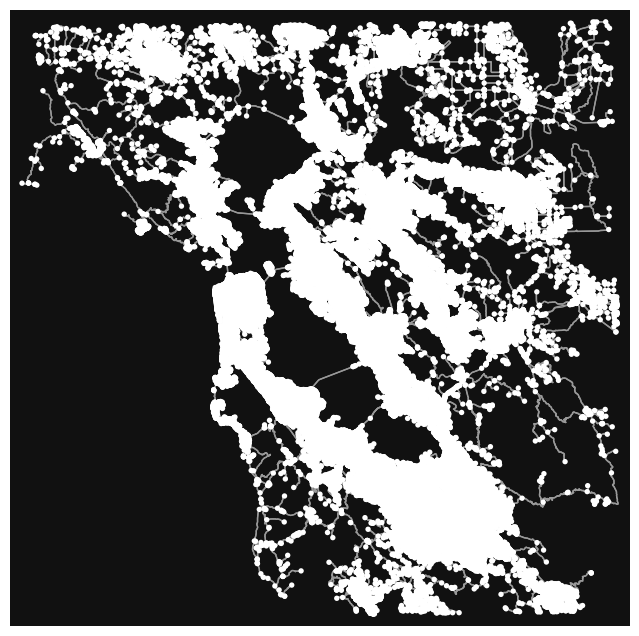

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
G = ox.graph_from_bbox(list(bay_area_block_data.total_bounds)[3], list(bay_area_block_data.total_bounds)[1], list(bay_area_block_data.total_bounds)[2], list(bay_area_block_data.total_bounds)[0], network_type='drive')
G = ox.project_graph(G)
ox.plot_graph(G, edge_linewidth=1.0)

### EV CO2

In [23]:
filename = 'CO2_ev.csv'
CO2 = pd.read_csv(filename)
block = bay_area_block_data
hexes = h3fy(block, resolution=8, clip=True)  # 8: edge length of approximately 0.74 km and spans an area of approximately 3 km²

In [24]:
# Initialize the Directions service with Mapbox access token
access_token = ''
directions_service = Directions(access_token=access_token)

def fetch_route(origin, destination):
    """ Fetch the shortest path using Mapbox Directions API """
    response = directions_service.directions([origin, destination], 'mapbox/driving')
    if response.status_code == 200:
        # Extract route as LineString if the response is successful
        routes = response.geojson()['features'][0]['geometry']
        return LineString(routes['coordinates'])
    else:
        return None

CO2 = CO2[['origin_bgrp_lng_2020',	'origin_bgrp_lat_2020', 'destination_bgrp_lng_2020', 'destination_bgrp_lat_2020', 'co2_emissions_grams']]
CO2.shape  # CO2 = CO2.sample(frac=0.001, random_state=42) 

(471407, 5)

In [25]:
# Use apply to create a new column 'shortest_path' with the LineString of the route
CO2['shortest_path'] = CO2.apply(lambda row: fetch_route(
    {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [row['origin_bgrp_lng_2020'], row['origin_bgrp_lat_2020']]}},
    {'type': 'Feature', 'geometry': {'type': 'Point', 'coordinates': [row['destination_bgrp_lng_2020'], row['destination_bgrp_lat_2020']]}
    }), axis=1)

# Convert CO2 to a GeoDataFrame with the new 'shortest_path' geometry
CO2_geo = gpd.GeoDataFrame(CO2, geometry='shortest_path', crs=hexes.crs)
CO2_geo['trip_id'] = CO2_geo.index
CO2_geo.head()

In [ ]:
CO2_geo.to_csv('Bay_EV_CO2.csv', index=False)

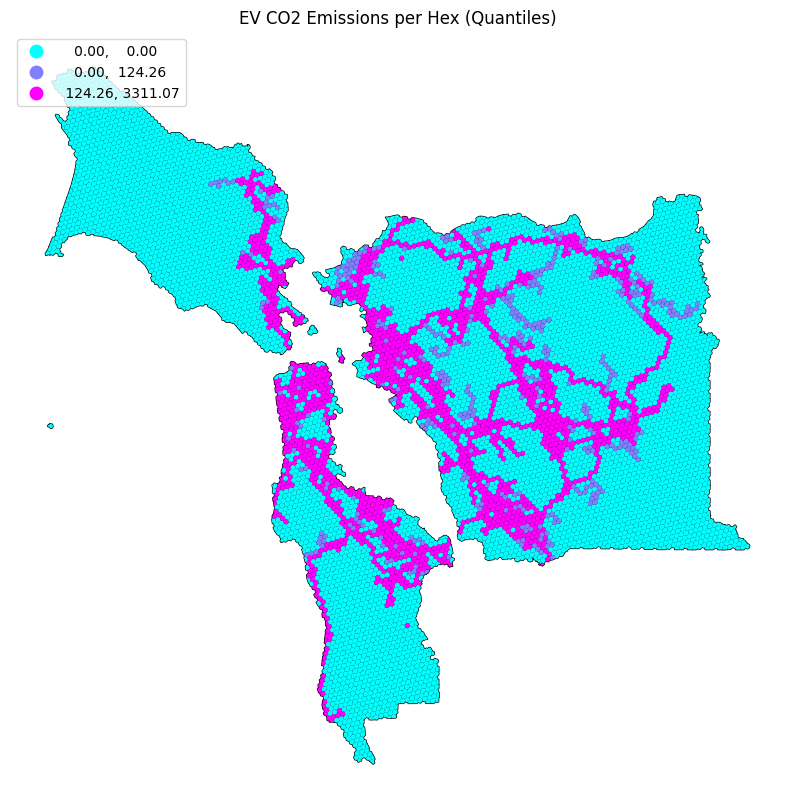

In [19]:
hexes = hexes.reset_index()

# Perform overlay operation
intersections = gpd.overlay(CO2_geo, hexes[['hex_id', 'geometry']], how='intersection', keep_geom_type=False)

# Calculate emissions per intersected hex
intersections['count'] = intersections.groupby('trip_id')['geometry'].transform('count')
intersections['emissions_per_hex'] = intersections['co2_emissions_grams'] / intersections['count']
total_emissions = intersections.groupby('hex_id')['emissions_per_hex'].sum().reset_index()

# Reset index before merging to avoid ambiguity
total_emissions = total_emissions.reset_index(drop=True)

# Merge with hexes and replace NaN values with zero
hexes = hexes.merge(total_emissions, on='hex_id', how='left')
hexes['emissions_per_hex'].fillna(0, inplace=True)

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
base = hexes.plot(color='white', edgecolor='black', ax=ax)
hexes.plot(ax=base, column='emissions_per_hex', cmap='cool', scheme='quantiles', k=5,   # cmap='cool' 'hot' 'viridis' 'plasma'  scheme='quantiles' 'equal_interval'
           legend=True, markersize=hexes['emissions_per_hex']/100, legend_kwds={'loc': 'lower left'}) 
ax.set_title('EV CO2 Emissions per Hex (Quantiles)')
ax.axis('off')
plt.show()

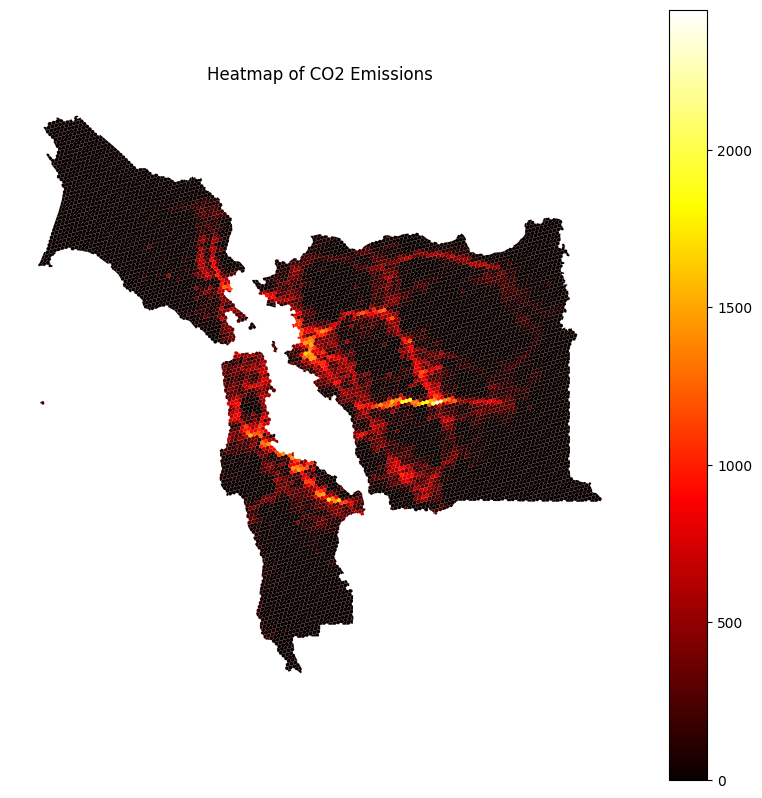

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
density = gaussian_filter(hexes['emissions_per_hex'], sigma=1)
hexes['density'] = density
hexes.plot(column='density', cmap='hot', legend=True, ax=ax)
ax.set_title('Heatmap of CO2 Emissions')
ax.axis('off')
plt.show()

Routing Network Visualization

In [ ]:
df = pd.read_csv('Bay_EV_CO2.csv')
df = df.drop(df.columns[[0]], axis=1)
df.head()

In [15]:
# Check if all entries are strings, if not, filter out the non-string entries
df = df[df['shortest_path'].apply(lambda x: isinstance(x, str))]
df['geometry'] = gpd.GeoSeries.from_wkt(df['shortest_path'])
df = gpd.GeoDataFrame(df, geometry='geometry')
df.set_crs(epsg=4326, inplace=True)

In [ ]:
G = ox.graph_from_place('New York City, New York, USA', network_type='drive')
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='gray', edge_linewidth=1.0)

# Highlight the routes by using a light green color and an appropriate line width
ev_route_lines = df.plot(ax=ax, linewidth=0.05, edgecolor='green', label='EV Routes')
legend = ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
for text in legend.get_texts():
    text.set_color('green')
plt.show()